### Classifying Digits

In this notebook, we'll be tackling the problem of classifying digits from images from the age-old MNIST dataset. We'll learn about how take raw data and run it through a pre-built classifier. In the process, we'll talk about cross validation and the sklearn library for python.

<img src="http://simonwinder.com/wp-content/uploads/2015/07/mnistExamples.png">

In [8]:
%matplotlib inline
# Add all your imports here
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.io import loadmat
from sklearn import svm

# Your data file
TRAIN = "train.mat"

The data is provided in a .mat file, which is typically used by MATLAB. However, a python library called scipy can help you load the file. Google for which method to call, add the required import, then call the function below.

You'll need to run `pip install scipy` to use scipy.

In [9]:
def get_data(mat_file):
    data = loadmat(mat_file)
    train_images = data["train_images"]
    train_labels = data["train_labels"].reshape((data["train_labels"].shape[0],))
    return train_images, train_labels

train_images, train_labels = get_data(TRAIN)
# this should be True, each image is 28x28 and there are 60000 train images
print train_images.shape == (28, 28, 60000)
# should be a single vector of size 60000, each item is a number 0-9
print train_labels.shape == (60000,)

True
True


Now, instead of our data being 28x28x60000, we would rather have our data be nxd, or 60000x784. Use `np.reshape` to convert our data to 784x60000, then use `np.swapaxes` to swap the axes around to make it 60000x784.

In [10]:
def reshape_images(images):
    """
        Images is 28 x 28 x 60000 array
    """
    # 784 x 60000
    pixels_features_to_samples = np.reshape(images, (784, images.shape[2]))
    # 60000 x 784
    samples_to_features = np.swapaxes(pixels_features_to_samples, 0, 1)
    return samples_to_features

train_images = reshape_images(train_images)
print train_images.shape == (60000, 784)

True


For your convenience, I've included the following function so that you can visualize an image from the data. Often, it helps to know what your data looks like.

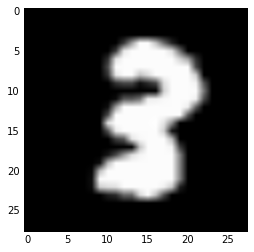

Image is:  3


In [11]:
def show_image(train_image_sample):
    rs = np.reshape(train_image_sample, (28, 28))
    plt.imshow(rs, cmap='gray')
    plt.show()
    
show_image(train_images[23523])
print "Image is: ", train_labels[23523]

Alright, now for the actual machine learning part. We're going to use a LinearSVC to classify our digits. In the past, we've only worked with only 2 classes in 2 dimensions, trying to find the line that best separates them. In the multi-dimensional case, LinearSVC will try to find the best line that separates 0 from everything else, then 1 from everything else, and so on. Thus, we'll have 10 different decision boundaries, but all of that happens under the hood so we don't really need to look into details for now.

First, we want to randomly shuffle the data. If you haven't realized, the first several thousand are 0's, the second are 1's, and so on. If we don't shuffle the data, we won't learn properly. So, to shuffle the data, instead of using `np.random.shuffle` on the data, we want to get shuffled indicies. So, if we only have 5 samples of data, we want to get shuffled indices such as [3,2,5,0,1] so that we can do `train_data[3,2,5,0,1]` and `train_labels[3,2,5,0,1]`. Look at the `random.sample` method. It takes in a list, which you can pass in a list or `range` of numbers between [0, 60000) and request 60000 numbers without replacement.

In [12]:
def random_indices(lst):
    return random.sample(lst, len(lst))

train_random_indices = random_indices(range(60000))
X, y = train_images[train_random_indices], train_labels[train_random_indices]

Now, we want to separate our data and labels into two groups, training and validation. We fit our data to the training data and check its performance on the validation set. If training accuracy is higher than our validation accuracy, it might mean that we have overfitted to the data. Generally, we want them to be similar. Implement the following function. Split is a number 0 < split < 1. If split is .75, then the first 3/4 of train_images is X_train and the last 1/4 is X_val.

In [13]:
def get_train_val_split(X, y, split):
    num_train = int(X.shape[0] * split)
    return X[:num_train], y[:num_train], X[num_train:], y[num_train:]

X_train, y_train, X_val, y_val = get_train_val_split(X, y, 0.05)
print X_train.shape == (45000, 784)

False


Let's train our data on the training set. Use `svm.LinearSVC` with parameter C=lambda defined in the method parameter. Use the `clf.fit` method to fit the data to the X_train and y_train.

In [14]:
def train(X_train, y_train, C=1):
    lin_clf = svm.LinearSVC(C=C)
    lin_clf.fit(X_train, y_train)
    return lin_clf

lin_clf = train(X_train, y_train, C=1)

Now, calculate the accuracy of the model. Use `clf.predict(X_val)` to get a `y_pred` and compare it with `y_val`. Return the number of predictions correct over the total number of items in the validation set.

In [15]:
def validate(clf, X_val, y_val):
    y_pred = clf.predict(X_val)
    return sum(y_val == y_pred) * 1. / X_val.shape[0]
    
validate(lin_clf, X_val, y_val)

0.75228070175438599

Next, we will do cross validation. Cross validation is the process of splitting up the training data into $k$ groups, training on $k - 1$ groups and validating on the remaining group. We do this $k$ times, with a different group used as the validation set at each time. Then, we take the $k$ individual accuracies and average them to get a cross validation score.

Now why do we use cross validation? A simple answer would be that we would like to see how our model generalizes to an independent dataset. Obviously, we would like to see if we're overfitting. In addition, we can use cross validation to help us choose our hyperparameters. A <b>hyperparameter</b> is like parameters that we can manually change. For example, the model we use, the constant lambda (or C in this case), for polynomial models, the max degree of the polynomial, etc. There are many hyperparameters and we can run cross validation on each set of hyperparameters and compare them to get the best hyperparameters.

So, how do we choose $k$? There isn't a really good answer and if you search it up, it's usually just what people feel like using. In general, if you have very little data, maybe you would consider leave one out cross validation, where if you have $n$ samples then your $k=n$, so you have n groups, or each group has 1 sample. Otherwise, it's safe to use $k=10$.

Let's get our data again and randomize it. Then implement cross validation. You should be able to use the `train` and `validate` methods you implemented before. We'll only use 5000 samples because training takes a long time. The hard part is to split the 5000 samples and labels into 2 groups, 1 composed of 4500 items and the other with 500 items. 

Hint: Use a range(X.shape[0]) to get a list of numbers between [0, X.shape[0]) to use as indicies, then split the list into 2 groups, training and validation, for each iteration in k iterations. Then do X_train = X[train_indices], and X_val = X[val_indices], and do the same for y.

In [18]:
train_random_indices = random_indices(range(60000))
X, y = train_images[train_random_indices], train_labels[train_random_indices]
# Take the first 5000 randomized samples
X, y = X[:5000], y[:5000]

In [19]:
def cross_validation(X, y, k=10):
    accuracies = []
    split_size = X.shape[0] / k
    indices = range(X.shape[0])
    for i in range(k):
        train_indices = indices[i * split_size: (i + 1) * split_size]
        val_indices = indices[:i * split_size] + indices[(i + 1) * split_size:]
        X_val, y_val = X[train_indices], y[train_indices]
        X_train, y_train = X[val_indices], y[val_indices]
        clf = train(X_train, y_train)
        accuracy = validate(clf, X_val, y_val)
        accuracies.append(accuracy)
        print "Accuracy for iteration {0} is {1}".format(i, accuracy)
    return sum(accuracies) * 1. / len(accuracies)

cross_validation(X, y, k=10)

Accuracy for iteration 0 is 0.752
Accuracy for iteration 1 is 0.774
Accuracy for iteration 2 is 0.758
Accuracy for iteration 3 is 0.804
Accuracy for iteration 4 is 0.784
Accuracy for iteration 5 is 0.794
Accuracy for iteration 6 is 0.794
Accuracy for iteration 7 is 0.776
Accuracy for iteration 8 is 0.754
Accuracy for iteration 9 is 0.732


0.7722

Now, let's reimplement `train` so we can pass in any model. Also, instead of using svm.LinearSVC, we will now use svm.SVC and define our kernel and other hyperparameters in a dictionary. This way, we can just through a list of hyperparameter dictionary and run cross validation. You can look up what `**` does.

In [20]:
def train(clf, X_train, y_train, C=1):
    clf.fit(X_train, y_train)
    return clf

clf = svm.LinearSVC(C=1)
print clf
clf = svm.SVC(kernel='linear', C=1)
print clf
hyperparams = {'kernel': 'linear', 'C': 1}
clf = svm.SVC(**hyperparams)
print clf

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Modify cross validation to use the new `train` method.

In [21]:
def cross_validation(clf, X, y, k=10):
    accuracies = []
    split_size = X.shape[0] / k
    indices = range(X.shape[0])
    for i in range(k):
        train_indices = indices[i * split_size: (i + 1) * split_size]
        val_indices = indices[:i * split_size] + indices[(i + 1) * split_size:]
        X_val, y_val = X[train_indices], y[train_indices]
        X_train, y_train = X[val_indices], y[val_indices]
        clf = train(clf, X_train, y_train)
        accuracy = validate(clf, X_val, y_val)
        accuracies.append(accuracy)
        print "Accuracy for iteration {0} is {1}".format(i, accuracy)
    return sum(accuracies) * 1. / len(accuracies)

Now, let's test several sets hyperparameters to see which one's best. Do add more hyperparameters to the list. This is for you to explore which hyperparameters is best. I don't know which is, so you tell me.

Refer to <a href="http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html">SVC documentation</a> to learn which hyperparameters are there.

In [22]:
h = [{'kernel': 'linear', 'C': 1}, {'kernel': 'poly', 'degree': 2, 'C': 1}]
for hyperparams in h:
    clf = svm.SVC(**hyperparams)
    acc = cross_validation(clf, X, y, k=10)
    print hyperparams
    print "Cross validation accuracy is {0}".format(acc)

Accuracy for iteration 0 is 0.87
Accuracy for iteration 1 is 0.884
Accuracy for iteration 2 is 0.868
Accuracy for iteration 3 is 0.888
Accuracy for iteration 4 is 0.886
Accuracy for iteration 5 is 0.874
Accuracy for iteration 6 is 0.892
Accuracy for iteration 7 is 0.858
Accuracy for iteration 8 is 0.866
Accuracy for iteration 9 is 0.864
{'kernel': 'linear', 'C': 1}
Cross validation accuracy is 0.875
Accuracy for iteration 0 is 0.94
Accuracy for iteration 1 is 0.936
Accuracy for iteration 2 is 0.922
Accuracy for iteration 3 is 0.94
Accuracy for iteration 4 is 0.94
Accuracy for iteration 5 is 0.94
Accuracy for iteration 6 is 0.928
Accuracy for iteration 7 is 0.926
Accuracy for iteration 8 is 0.94
Accuracy for iteration 9 is 0.928
{'kernel': 'poly', 'C': 1, 'degree': 2}
Cross validation accuracy is 0.934
